In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
import joblib

# Check if MPS is available and set the device accordingly
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

df = pd.read_csv('result.csv')

df


Using device: mps


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,popularity,speechiness,tempo,valence,popularity_level
0,0.84800,0.400,165360,0.205,0.000000,7,0.4000,-11.794,1.0,0.0270,79.545,0.357,0
1,0.56000,0.686,127027,0.844,0.000001,10,0.1200,-6.163,2.0,0.0484,109.039,0.897,0
2,0.57100,0.467,148533,0.277,0.001160,9,0.0762,-13.049,5.0,0.0302,86.895,0.597,0
3,0.78900,0.522,134520,0.673,0.000000,11,0.3180,-3.480,5.0,0.0425,141.010,0.659,0
4,0.60800,0.635,145013,0.829,0.000000,9,0.1860,-5.125,6.0,0.0471,139.426,0.963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9511,0.02640,0.611,132303,0.688,0.000000,1,0.2510,-5.688,94.0,0.3410,178.462,0.393,2
9512,0.69200,0.824,209438,0.588,0.000104,6,0.1490,-6.400,94.0,0.0924,98.027,0.513,2
9513,0.32100,0.834,247059,0.454,0.000006,1,0.1140,-9.750,95.0,0.2010,81.618,0.837,2
9514,0.10400,0.896,196653,0.586,0.000000,10,0.7900,-6.687,95.0,0.0559,116.971,0.642,2


In [30]:
# Define features and target
features = ["loudness", "energy", "speechiness", "danceability", "tempo", "key", "liveness", "instrumentalness", "valence", "acousticness", "duration_ms"]
target = "popularity_level"

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('minmax', StandardScaler(), [
        'tempo', 'duration_ms', 'loudness', 
        'energy', 'speechiness', 'danceability', 'liveness', 
        'instrumentalness', 'valence',  
        'acousticness'
    ]),
    ('categorical', OneHotEncoder(), ['key'])
], remainder='passthrough')

# Creating a pipeline with make_pipeline
pipeline = make_pipeline(preprocessor)

# Fit and transform the data using the pipeline
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

# Print shape to determine input size
print(X_train_transformed.shape)

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.45)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.45)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.45)
        
        self.fc4 = nn.Linear(32, 3)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Initialize the model with the correct input size
input_size = X_train_transformed.shape[1]
model = Net(input_size).to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)



# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted_classes = torch.max(predictions, 1)
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

import matplotlib.pyplot as plt
# Initialize lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop with evaluation
epochs = 5000
from tqdm import tqdm
progress_bar = tqdm(range(epochs), desc='Training')

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)

            # Calculate accuracy
            train_accuracy = calculate_accuracy(outputs, y_train_tensor)
            test_accuracy = calculate_accuracy(test_outputs, y_test_tensor)

            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            train_accuracies.append(train_accuracy.item())
            test_accuracies.append(test_accuracy.item())
            
            progress_bar.set_postfix({
                'Training Loss': f'{loss.item():.4f}',
                'Test Loss': f'{test_loss.item():.4f}',
                'Training Accuracy': f'{train_accuracy:.4f}',
                'Test Accuracy': f'{test_accuracy:.4f}'
            })

(7612, 22)


Training: 100%|██████████| 5000/5000 [01:11<00:00, 69.45it/s, Training Loss=0.9461, Test Loss=0.9490, Training Accuracy=0.5385, Test Accuracy=0.5352]


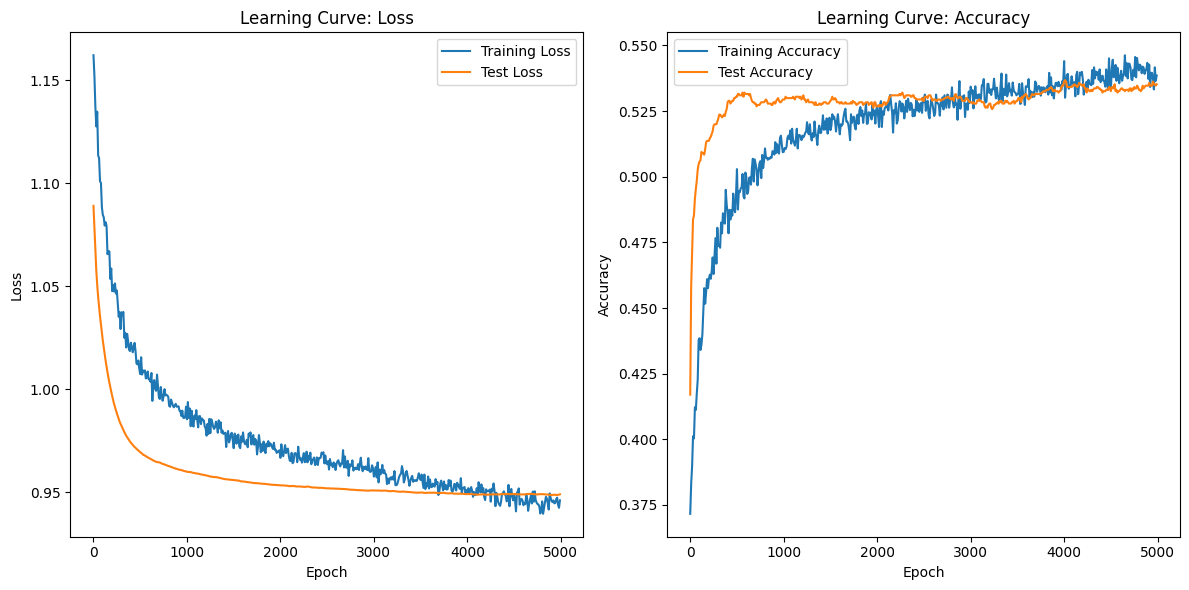

In [31]:
# Plotting the learning curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(0, epochs, 10), train_losses, label='Training Loss')
plt.plot(range(0, epochs, 10), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve: Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, epochs, 10), train_accuracies, label='Training Accuracy')
plt.plot(range(0, epochs, 10), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve: Accuracy')

plt.tight_layout()
plt.show()

In [32]:
# Save the entire model
torch.save(model, 'model_fine_tuned.pth')

# Save the preprocessing pipeline
joblib.dump(pipeline, 'preprocessing_pipeline_fine_tuned.pkl')

['preprocessing_pipeline_fine_tuned.pkl']